Sentiment Analysis Notebook
This notebook demonstrates end-to-end sentiment analysis on textual data (tweets, reviews, etc.). It covers:

Data loading (CSV or sample data)
Exploratory data analysis (EDA)
Text preprocessing and feature engineering
Classical ML model (TF-IDF + Logistic Regression)
Transformer-based approach (Hugging Face transformers) for fine-tuning
Evaluation, error analysis, and insights

Class distribution:
label
neutral     41
positive    30
negative    29
Name: count, dtype: int64

Sample data:
                                          text     label
11  The product does what it's supposed to do.   neutral
5       Delivers great performance every time.  positive
62       Amazing service, couldn't be happier.  positive
20      Average experience, nothing memorable.   neutral
15               It was okay, nothing special.   neutral


  0%|          | 0/100 [00:00<?, ?it/s]


After preprocessing:
                                    text                           text_clean  \
0       Best product I've used in years.       best product ive used in years   
1  Absolutely awful, never buying again.  absolutely awful never buying again   
2    The experience was neutral overall.   the experience was neutral overall   
3    Completely useless, waste of money.    completely useless waste of money   
4   Terrible service, very disappointed.   terrible service very disappointed   

      label  
0  positive  
1  negative  
2   neutral  
3  negative  
4  negative  

Train size: 80, Test size: 20

TF-IDF vector shape: (80, 218)

Model Accuracy: 0.9

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.83      0.83         6
     neutral       0.89      1.00      0.94         8
    positive       1.00      0.83      0.91         6

    accuracy                           0.90        20
   macro avg       0.91    

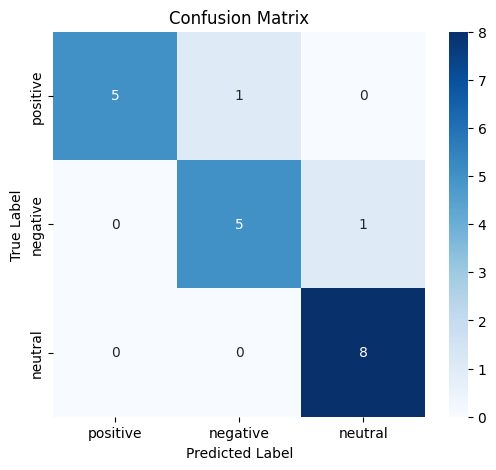


Detailed Prediction Results (first 15):


,text,true_label,predicted_label,correct
0,it was okay nothing special,neutral,neutral,True
1,best product ive used in years,positive,positive,True
2,service was acceptable nothing more,neutral,neutral,True
3,i absolutely love this product,positive,negative,False
4,worst experience ever avoid this product,negative,negative,True
5,fairly satisfied but not excited,neutral,neutral,True
6,delivery was extremely late and stressful,negative,negative,True
7,delivers great performance every time,positive,positive,True
8,frustrating experience from start to end,negative,neutral,False
9,worst experience ever avoid this product,negative,negative,True



Number of misclassified samples: 2


,text,true_label,predicted_label,correct
3,i absolutely love this product,positive,negative,False
8,frustrating experience from start to end,negative,neutral,False



FINAL SUMMARY
Total Test Samples: 20
Accuracy: 90.0%
Misclassified Samples: 2

Predictions on new texts:


,text,predicted_sentiment
0,I am extremely happy with the service!,positive
1,This was a total waste of money.,negative
2,"It's okay, nothing special but nothing bad eit...",neutral


In [1]:
# ============================================
# SENTIMENT ANALYSIS - CLEAN & REALISTIC NOTEBOOK
# ============================================

# 1. IMPORTS
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ============================================
# 2. CREATE A BALANCED DATASET (NO DUPLICATES LEAKAGE)
# ============================================

# Positive class (10 unique sentences)
positive_samples = [
    "I absolutely love this product!",
    "This purchase made me really happy.",
    "The quality is fantastic and top-notch.",
    "Amazing service, couldn't be happier.",
    "Exceeded my expectations completely.",
    "Superb experience, highly recommend it.",
    "Best product I've used in years.",
    "Delivers great performance every time.",
    "Very satisfied and will buy again.",
    "Works perfectly, no complaints at all."
]

# Negative class (10 unique sentences)
negative_samples = [
    "Terrible service, very disappointed.",
    "Worst experience ever, avoid this product.",
    "Broke within a few days, very poor quality.",
    "Customer support was rude and unhelpful.",
    "Completely useless, waste of money.",
    "Frustrating experience from start to end.",
    "Defective product, very unhappy.",
    "Delivery was extremely late and stressful.",
    "Nothing like what was described.",
    "Absolutely awful, never buying again."
]

# Neutral class (10 unique sentences)
neutral_samples = [
    "It was okay, nothing special.",
    "Average experience, nothing memorable.",
    "The product does what it's supposed to do.",
    "Customer support was slow but helped eventually.",
    "Neither good nor bad, just okay.",
    "Service was acceptable, nothing more.",
    "Decent quality for the price.",
    "Fairly satisfied but not excited.",
    "The experience was neutral overall.",
    "Met expectations but didn’t impress."
]

# Combine into a DataFrame
df = pd.DataFrame({
    "text": positive_samples + negative_samples + neutral_samples,
    "label": ["positive"] * 10 + ["negative"] * 10 + ["neutral"] * 10
})

# Upsample randomly to 100 samples with replacement
df = df.sample(100, replace=True, random_state=42).reset_index(drop=True)

print("Class distribution:")
print(df['label'].value_counts())
print("\nSample data:")
print(df.sample(5))

# ============================================
# 3. TEXT PREPROCESSING
# ============================================

def preprocess_text(text):
    """
    Cleans the text by:
    - Lowercasing
    - Removing URLs, mentions, punctuation
    - Normalizing spaces
    """
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#(\w+)', r'\1', text)  # keep hashtag text only
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # normalize spaces
    return text

tqdm.pandas()
df['text_clean'] = df['text'].progress_map(preprocess_text)

print("\nAfter preprocessing:")
print(df[['text', 'text_clean', 'label']].head())

# ============================================
# 4. TRAIN-TEST SPLIT (STRATIFIED)
# ============================================
X = df['text_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")

# ============================================
# 5. TF-IDF VECTORIZATION
# ============================================
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2), min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("\nTF-IDF vector shape:", X_train_tfidf.shape)

# ============================================
# 6. LOGISTIC REGRESSION MODEL
# ============================================
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

# ============================================
# 7. PREDICTIONS & METRICS
# ============================================
y_pred = clf.predict(X_test_tfidf)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy:", round(accuracy, 4))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative", "neutral"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["positive", "negative", "neutral"],
            yticklabels=["positive", "negative", "neutral"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ============================================
# 8. DETAILED PREDICTION RESULTS
# ============================================

results_df = pd.DataFrame({
    'text': X_test.values,
    'true_label': y_test.values,
    'predicted_label': y_pred
}).reset_index(drop=True)

results_df['correct'] = results_df['true_label'] == results_df['predicted_label']

print("\nDetailed Prediction Results (first 15):")
display(results_df.head(15))

# ============================================
# 9. ERROR ANALYSIS
# ============================================

misclassified_df = results_df[results_df['correct'] == False]
print(f"\nNumber of misclassified samples: {len(misclassified_df)}")
if len(misclassified_df) > 0:
    display(misclassified_df)
else:
    print("No misclassifications!")

# ============================================
# 10. FINAL SUMMARY
# ============================================

print("\nFINAL SUMMARY")
print(f"Total Test Samples: {len(X_test)}")
print(f"Accuracy: {round(accuracy*100, 2)}%")
print(f"Misclassified Samples: {len(misclassified_df)}")

# ============================================
# 11. TRY NEW PREDICTIONS
# ============================================

def predict_sentiment(new_texts):
    clean_texts = [preprocess_text(t) for t in new_texts]
    features = vectorizer.transform(clean_texts)
    preds = clf.predict(features)
    return pd.DataFrame({"text": new_texts, "predicted_sentiment": preds})

# Example
new_examples = [
    "I am extremely happy with the service!",
    "This was a total waste of money.",
    "It's okay, nothing special but nothing bad either."
]
print("\nPredictions on new texts:")
display(predict_sentiment(new_examples))
